# Distributed Coverage Control with Voronoi Partition Visualization
Each robot observes local neighbors and estimates its Voronoi cell, then moves toward the centroid of the cell.
This simulates decentralized coverage while showing each robot's local coverage area.

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import animation
from shapely.geometry import Polygon as SPolygon, Point
from scipy.spatial import Voronoi

In [62]:
# Domain and density
polygon_vertices = np.array([[1, 0], [0.5, np.sqrt(3)/2], [-0.5, np.sqrt(3)/2],
                             [-1, 0], [-0.5, -np.sqrt(3)/2], [0.5, -np.sqrt(3)/2]])
def phi(x, y): return np.exp(-x**2 - y**2)
x = np.linspace(-1.5, 1.5, 300)
y = np.linspace(-2.0, 1.5, 300)
X, Y = np.meshgrid(x, y)
Z = phi(X, Y)

In [63]:
# Local sensing and centroid estimation
def find_neighbors(pos, radius=0.8):
    n = len(pos)
    neighbors = [[] for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i != j and np.linalg.norm(pos[i] - pos[j]) <= radius:
                neighbors[i].append(j)
    return neighbors

def compute_centroid(local_points, domain):
    if len(local_points) < 3:
        return np.mean(local_points, axis=0)
    try:
        vor = Voronoi(local_points)
        region = vor.regions[vor.point_region[0]]
        if not region or -1 in region:
            return local_points[0]
        poly_pts = [vor.vertices[i] for i in region]
        vpoly = SPolygon(poly_pts)
        clipped = vpoly.intersection(SPolygon(domain))
        if clipped.is_empty:
            return local_points[0]
        return np.array(clipped.centroid.coords[0])
    except:
        return local_points[0]

In [64]:
# Initialization and simulation
np.random.seed(42)
num_robots = 15
theta = np.linspace(-np.pi/3, -2*np.pi/3, num_robots)  # góc từ -60° đến -120°
r = 1.4  # khoảng cách nằm ngoài polygon
x_positions = r * np.cos(theta)
y_positions = r * np.sin(theta)
y_positions += np.random.uniform(-0.05, 0.05, num_robots)
robot_positions = np.column_stack((x_positions, y_positions))
positions = [robot_positions.copy()]
for _ in range(100):
    current = positions[-1]
    new_pos = []
    neighbors = find_neighbors(current, radius=3.0)
    for i in range(num_robots):
        local_group = [current[i]] + [current[j] for j in neighbors[i]]
        centroid = compute_centroid(np.array(local_group), polygon_vertices.tolist())
        moved = current[i] + 0.6 * (centroid - current[i])
        new_pos.append(moved)
    positions.append(np.array(new_pos))

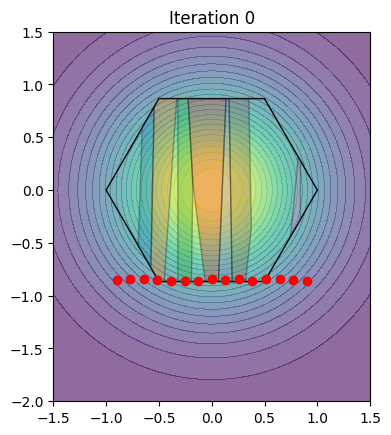

In [65]:
# Visualization with Voronoi partitions
fig, ax = plt.subplots()
def animate(i):
    ax.clear()
    ax.set_title(f"Iteration {i}")
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-2.0, 1.5)
    ax.set_aspect('equal')
    ax.contourf(X, Y, Z, levels=30, cmap='viridis', alpha=0.6)
    ax.add_patch(Polygon(polygon_vertices, closed=True, edgecolor='black', facecolor='none'))
    current = positions[i]
    neighbors = find_neighbors(current, radius=3.0)
    for k in range(len(current)):
        local_group = [current[k]] + [current[j] for j in neighbors[k]]
        if len(local_group) >= 3:
            try:
                vor = Voronoi(local_group)
                region = vor.regions[vor.point_region[0]]
                if not region or -1 in region: continue
                poly_pts = [vor.vertices[t] for t in region]
                vpoly = SPolygon(poly_pts)
                clipped = vpoly.intersection(SPolygon(polygon_vertices))
                if not clipped.is_empty and clipped.geom_type == 'Polygon':
                    xx, yy = clipped.exterior.xy
                    ax.fill(xx, yy, alpha=0.3, edgecolor='black')
            except: continue
    ax.plot(current[:, 0], current[:, 1], 'ro')
from IPython.display import HTML
ani = animation.FuncAnimation(fig, animate, frames=len(positions), interval=300)
HTML(ani.to_jshtml())